## Digit Classification with Convolutional Neural Network

Import libraries and load data

In [1]:
import torch
import torch.nn as nn
from torch.nn import Dropout
import torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import os
import json
from pathlib import Path


transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])

# define path to store data
trainset_path = '/Users/seangorman/code-projects/deep-digits/trainset'
testset_path = '/Users/seangorman/code-projects/deep-digits/testset'

# check if trainset and testset already exist at the specified paths
def download_data(path):
    if not os.path.exists(path):
        data = datasets.MNIST(path, download=True, train=True, transform=transform)
        print('Trainset downloaded')
        return data
    else:
        data = datasets.MNIST(path, train=True, transform=transform)
        print('Trainset already exists')
        return data

trainset = download_data(trainset_path)
testset = download_data(testset_path)

Trainset already exists
Trainset already exists


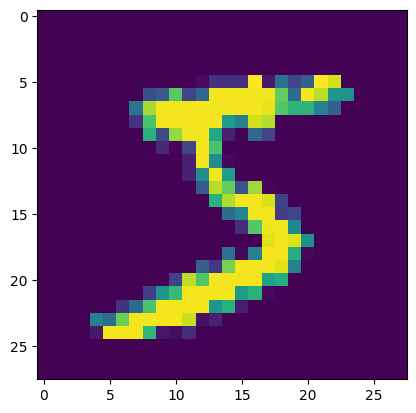

In [2]:
image, label = trainset[0]

# convert the tensor back to an image
image = transforms.ToPILImage()(image)

# display the image
plt.imshow(image)
plt.show()

In [24]:
## Hyperparameters
batch_size = 64
learning_rate = 0.003
dropout = 0.2
epochs = 10


In [4]:
# define the trainloader and testloader
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True)

# Visualising data batching
batch_X, batch_y = next(iter(trainloader))
print ("Sample batch:\n"
    f"  X: {list(batch_X.size())}\n"
    f"  y: {list(batch_y.size())}\n"
    "Sample point:\n"
    f"  X: {batch_X[0]}\n"
    f"  y: {batch_y[0]}")

Sample batch:
  X: [64, 1, 28, 28]
  y: [64]
Sample point:
  X: tensor([[[-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1

Define evaluation metric function

In [ ]:
#define evaluation function 
from sklearn.metrics import precision_recall_fscore_support
import numpy as np

def get_metrics(y_true, y_pred, classes):
    # Performance
    performance = {"overall": {}, "class": {}}

    # Overall performance
    metrics = precision_recall_fscore_support(y_true, y_pred, average="weighted")
    performance["overall"]["precision"] = metrics[0]
    performance["overall"]["recall"] = metrics[1]
    performance["overall"]["f1"] = metrics[2]
    performance["overall"]["num_samples"] = np.float64(len(y_true))

    # Per-class performance
    metrics = precision_recall_fscore_support(y_true, y_pred, average=None)
    for i in range(len(classes)):
        performance["class"][classes[i]] = {
            "precision": metrics[0][i],
            "recall": metrics[1][i],
            "f1": metrics[2][i],
            "num_samples": np.float64(metrics[3][i]),
        }

    return performance

Construct Model

In [30]:
# Construct a CNN
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)     #input of 1, output of 32 filters, kernel size of 3x3, stride of 1 (moves 1 pixel at a time)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)    #input of 32, output of 64 filters, kernel size of 3x3, stride of 1 (moves 1 pixel at a time)
        self.dropout1 = Dropout(dropout)
        self.dropout2 = Dropout(dropout)
        self.fc1 = nn.Linear(9216, 128)         #input of 9216 (Output of conv2, then pooled), output of 128
        self.fc2 = nn.Linear(128, 10)  

 

    def forward(self, x):
        x = self.conv1(x)       #x enters of shape (batch_size, 1, 28, 28)
        x = F.relu(x)           #x is of shape (batch_size, 32, 26, 26), 3x3 kernels leaves behind 2 pixels at each edge 
        x = self.conv2(x)   
        x = F.relu(x)           #x is of shape (batch_size, 64, 24, 24)
        x = F.max_pool2d(x, 2)  #x is of shape (batch_size, 64, 12, 12)
        x = self.dropout1(x)
        x = torch.flatten(x, 1) #after flattening x is of shape (batch_size, 9216 (64*12*12))) 
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)         #x is of shape (batch_size, 10), where each element in "10" is the probability of the image being a digit 0-9
        output = F.log_softmax(x, dim=1)
        return output


model = CNN()
# print model parameters
print(sum(p.numel() for p in model.parameters()), 'Model parameters')

1199882 Model parameters


In [31]:
# define the loss function and the optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Train Model

In [32]:
# Main training loop
losses = []
for epoch in range(epochs):
    # Training
    train_loss = 0.0
    train_accuracy = 0.0
    for images, labels in trainloader:
        optimizer.zero_grad()
        outputs = model(images)             #make preds in forward pass
        loss = criterion(outputs, labels)   #calculate loss
        loss.backward()                     #backpropagate loss
        optimizer.step()                    #update weights
        train_loss += loss.item() * images.size(0)
        _, prediction = torch.max(outputs.data, 1)  #_ is a throwaway variable (max value in each batch), prediction is the index of the max value
        train_accuracy += (prediction == labels).sum().item()
    losses.append(train_loss)
    train_loss = train_loss / len(trainloader.dataset)
    train_accuracy = train_accuracy / len(trainloader.dataset)
    print('Epoch: {} \tTraining Loss: {:.6f} \tTraining Accuracy: {:.6f}'.format(epoch+1, train_loss, train_accuracy))



Epoch: 1 	Training Loss: 0.136033 	Training Accuracy: 0.958817
Epoch: 2 	Training Loss: 0.058782 	Training Accuracy: 0.982117
Epoch: 3 	Training Loss: 0.041056 	Training Accuracy: 0.987667
Epoch: 4 	Training Loss: 0.034460 	Training Accuracy: 0.989433
Epoch: 5 	Training Loss: 0.030347 	Training Accuracy: 0.990217
Epoch: 6 	Training Loss: 0.026257 	Training Accuracy: 0.992000
Epoch: 7 	Training Loss: 0.023562 	Training Accuracy: 0.992533
Epoch: 8 	Training Loss: 0.022522 	Training Accuracy: 0.992750
Epoch: 9 	Training Loss: 0.019690 	Training Accuracy: 0.993850
Epoch: 10 	Training Loss: 0.016622 	Training Accuracy: 0.994983


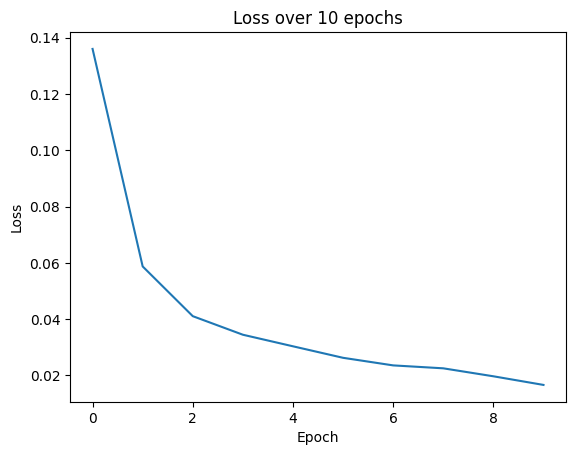

In [52]:
#plot the loss
losses = [0.136033, 0.0587282, 0.041056, 0.034460, 0.030347, 0.026257, 0.023562, 0.022522, 0.019690, 0.016622]
plt.plot(losses)
plt.title('Loss over 10 epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.savefig('CNN-loss-over-time.png', dpi = 120)

Evaluate Model

In [41]:
# Testing
test_loss = 0.0
test_accuracy = 0.0
with torch.no_grad():
    model.eval()
    y_trues, y_preds = [], []
    for images, labels in testloader:
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item() * images.size(0)
        _, prediction = torch.max(outputs.data, 1)
        test_accuracy += (prediction == labels).sum().item()
        y_trues.extend(labels)
        y_preds.extend(prediction)
    print('Test Loss: {:.6f} \tTest Accuracy: {:.6f}'.format(test_loss/len(testloader.dataset), test_accuracy/len(testloader.dataset)))

Test Loss: 0.000000 	Test Accuracy: 0.001067
Test Loss: 0.000002 	Test Accuracy: 0.002133
Test Loss: 0.000004 	Test Accuracy: 0.003200
Test Loss: 0.000005 	Test Accuracy: 0.004267
Test Loss: 0.000005 	Test Accuracy: 0.005333
Test Loss: 0.000027 	Test Accuracy: 0.006383
Test Loss: 0.000028 	Test Accuracy: 0.007450
Test Loss: 0.000029 	Test Accuracy: 0.008517
Test Loss: 0.000030 	Test Accuracy: 0.009583
Test Loss: 0.000030 	Test Accuracy: 0.010650
Test Loss: 0.000032 	Test Accuracy: 0.011717
Test Loss: 0.000038 	Test Accuracy: 0.012783
Test Loss: 0.000038 	Test Accuracy: 0.013850
Test Loss: 0.000038 	Test Accuracy: 0.014917
Test Loss: 0.000039 	Test Accuracy: 0.015983
Test Loss: 0.000040 	Test Accuracy: 0.017050
Test Loss: 0.000044 	Test Accuracy: 0.018117
Test Loss: 0.000044 	Test Accuracy: 0.019183
Test Loss: 0.000047 	Test Accuracy: 0.020250
Test Loss: 0.000048 	Test Accuracy: 0.021317
Test Loss: 0.000048 	Test Accuracy: 0.022383
Test Loss: 0.000051 	Test Accuracy: 0.023450
Test Loss:

In [42]:
classes = [i for i in range(10)]

performance = get_metrics(y_trues, y_preds, classes)

print(json.dumps(performance["overall"], indent=2))

{
  "precision": 0.998684516831351,
  "recall": 0.9986833333333334,
  "f1": 0.9986832272223732,
  "num_samples": 60000.0
}


Save Model

In [44]:


# Save model
dir = Path("CNN")
dir.mkdir(parents=True, exist_ok=True)
torch.save(model.state_dict(), Path(dir, "model.pt"))
with open(Path(dir, 'performance.json'), "w") as fp:
    json.dump(performance, indent=2, sort_keys=False, fp=fp)

Making individual inference

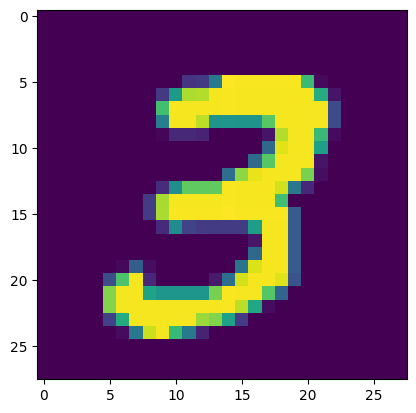

3


In [50]:
#Make predictions for a single image
image, label = testset[7]
plt.imshow(image.numpy().squeeze());
plt.show()

#reshape image to (1, 1, 28, 28) to match the input shape of the model
image = image.reshape(1, 1, 28, 28)

# Turn off gradients for validation, saves memory and computations
with torch.no_grad():
    model.eval()
    pred_probs = model(image)
    ps = torch.exp(pred_probs)
    top_p, top_class = ps.topk(1, dim=1)
    print(top_class.item())